# 1. Prepare Datasets

## Import the S3 data into SageMaker

In [31]:
# Import packages
import boto3
import sagemaker
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start SageMaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Store S3 locations

In [32]:
s3_public_path_tuition = "s3://collegeaffordability317/TuitionTracker/"
s3_public_path_usda = "s3://collegeaffordability317/USDA/"

In [33]:
%store s3_public_path_tuition
%store s3_public_path_usda

Stored 's3_public_path_tuition' (str)
Stored 's3_public_path_usda' (str)


## Show all the data files for the project

In [34]:
!aws s3 ls $s3_public_path_tuition

2024-03-17 16:07:00      21527 DataDictionary.xlsx
2024-03-17 16:07:00     838246 GradRates.csv
2024-03-17 16:07:01    1319314 NetPrice.csv
2024-03-17 16:07:01    1382164 RetentionRates.csv
2024-03-17 16:07:02     653000 StickerPrice.csv


We will only need StickerPrice.csv and NetPrice.csv

In [35]:
!aws s3 ls $s3_public_path_usda

2024-03-17 16:06:57    1610608 Education.xlsx
2024-03-21 01:19:41     450599 PovertyEstimates.csv
2024-03-21 01:19:41    2187886 Unemployment.csv


We will only need PovertyEstimates.csv and Unemployment.csv

# 2. Athena DB

In [36]:
from pyathena import connect

# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [37]:
# Set database name
database_name = 'college_affordability'

In [38]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [39]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


In [40]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,college_afford
1,college_affordability
2,collegeaff
3,collegeaffordability317
4,default


In [41]:
tuitiontracker_dir = 's3://collegeaffordability317/TuitionTracker/'

In [42]:
# Drop the table if it already exists
table_name_1 = 'StickerPrice'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name_1}', conn)

# Define the CREATE TABLE statement with data types in lowercase
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_1} (
    unit_id int,
    institution_name varchar(255),
    sector int,
    total_price_in_state_on_campus_2021_2022 double,
    total_price_in_state_off_campus_wo_fam_2021_2022 double,
    total_price_in_state_off_campus_w_fam_2021_2022 double,
    total_price_in_state_on_campus_2020_2021 double,
    total_price_in_state_off_campus_wo_fam_2020_2021 double,
    total_price_in_state_off_campus_w_fam_2020_2021 double,
    total_price_in_state_on_campus_2019_2020 double,
    total_price_in_state_off_campus_wo_fam_2019_2020 double,
    total_price_in_state_off_campus_w_fam_2019_2020 double,
    total_price_in_state_on_campus_2018_2019 double,
    total_price_in_state_off_campus_wo_fam_2018_2019 double,
    total_price_in_state_off_campus_w_fam_2018_2019 double,
    total_price_in_state_on_campus_2017_2018 double,
    total_price_in_state_off_campus_wo_fam_2017_2018 double,
    total_price_in_state_off_campus_w_fam_2017_2018 double,
    total_price_in_state_on_campus_2016_2017 double,
    total_price_in_state_off_campus_wo_fam_2016_2017 double,
    total_price_in_state_off_campus_w_fam_2016_2017 double,
    total_price_in_state_on_campus_2015_2016 double,
    total_price_in_state_off_campus_wo_fam_2015_2016 double,
    total_price_in_state_off_campus_w_fam_2015_2016 double,
    total_price_in_state_on_campus_2014_2015 double,
    total_price_in_state_off_campus_wo_fam_2014_2015 double,
    total_price_in_state_off_campus_w_fam_2014_2015 double,
    total_price_in_state_on_campus_2013_2014 double,
    total_price_in_state_off_campus_wo_fam_2013_2014 double,
    total_price_in_state_off_campus_w_fam_2013_2014 double,
    total_price_in_state_on_campus_2012_2013 double,
    total_price_in_state_off_campus_wo_fam_2012_2013 double,
    total_price_in_state_off_campus_w_fam_2012_2013 double,
    total_price_in_state_on_campus_2011_2012 double,
    total_price_in_state_off_campus_wo_fam_2011_2012 double,
    total_price_in_state_off_campus_w_fam_2011_2012 double
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{tuitiontracker_dir}/{table_name_1}'
"""

In [43]:
# Execute the CREATE TABLE statement
pd.read_sql(statement, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name_1} LIMIT 5', conn)

,unit_id,institution_name,sector,total_price_in_state_on_campus_2021_2022,total_price_in_state_off_campus_wo_fam_2021_2022,total_price_in_state_off_campus_w_fam_2021_2022,total_price_in_state_on_campus_2020_2021,total_price_in_state_off_campus_wo_fam_2020_2021,total_price_in_state_off_campus_w_fam_2020_2021,total_price_in_state_on_campus_2019_2020,...,total_price_in_state_off_campus_w_fam_2014_2015,total_price_in_state_on_campus_2013_2014,total_price_in_state_off_campus_wo_fam_2013_2014,total_price_in_state_off_campus_w_fam_2013_2014,total_price_in_state_on_campus_2012_2013,total_price_in_state_off_campus_wo_fam_2012_2013,total_price_in_state_off_campus_w_fam_2012_2013,total_price_in_state_on_campus_2011_2012,total_price_in_state_off_campus_wo_fam_2011_2012,total_price_in_state_off_campus_w_fam_2011_2012


In [44]:
# Drop the table if it already exists
table_name_2 = 'NetPrice'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name_2}', conn)

# Define the CREATE TABLE statement with data types in lowercase
statement = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_2} (
    unit_id int,
    institution_name varchar(255),
    sector int,
    avg_net_price_grants_scholarship_2020_2021 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2020_2021 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2020_2021 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2020_2021 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2020_2021 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2020_2021 double,
    avg_net_price_grants_scholarship_2019_2020 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2019_2020 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2019_2020 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2019_2020 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2019_2020 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2019_2020 double,
    avg_net_price_grants_scholarship_2018_2019 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2018_2019 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2018_2019 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2018_2019 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2018_2019 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2018_2019 double,
    avg_net_price_grants_scholarship_2017_2018 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2017_2018 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2017_2018 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2017_2018 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2017_2018 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2017_2018 double,
    avg_net_price_grants_scholarship_2016_2017 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2016_2017 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2016_2017 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2016_2017 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2016_2017 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2016_2017 double,
    avg_net_price_grants_scholarship_2015_2016 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2015_2016 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2015_2016 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2015_2016 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2015_2016 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2015_2016 double,
    avg_net_price_grants_scholarship_2014_2015 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2014_2015 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2014_2015 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2014_2015 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2014_2015 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2014_2015 double,
    avg_net_price_grants_scholarship_2013_2014 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2013_2014 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2013_2014 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2013_2014 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2013_2014 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2013_2014 double,
    avg_net_price_grants_scholarship_2012_2013 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2012_2013 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2012_2013 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2012_2013 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2012_2013 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013 double,
    avg_net_price_grants_scholarship_2011_2012 double,
    avg_net_price_income_0_30k_titleiv_fed_finaid_2011_2012 double,
    avg_net_price_income_30k_48k_titleiv_fed_finaid_2011_2012 double,
    avg_net_price_income_48k_75k_titleiv_fed_finaid_2011_2012 double,
    avg_net_price_income_75k_110k_titleiv_fed_finaid_2011_2012 double,
    avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012 double
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{tuitiontracker_dir}/{table_name_2}'
"""

In [45]:
# Execute the CREATE TABLE statement
pd.read_sql(statement, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name_2} LIMIT 5', conn)

,unit_id,institution_name,sector,avg_net_price_grants_scholarship_2020_2021,avg_net_price_income_0_30k_titleiv_fed_finaid_2020_2021,avg_net_price_income_30k_48k_titleiv_fed_finaid_2020_2021,avg_net_price_income_48k_75k_titleiv_fed_finaid_2020_2021,avg_net_price_income_75k_110k_titleiv_fed_finaid_2020_2021,avg_net_price_income_over_110k_titleiv_fed_finaid_2020_2021,avg_net_price_grants_scholarship_2019_2020,...,avg_net_price_income_30k_48k_titleiv_fed_finaid_2012_2013,avg_net_price_income_48k_75k_titleiv_fed_finaid_2012_2013,avg_net_price_income_75k_110k_titleiv_fed_finaid_2012_2013,avg_net_price_income_over_110k_titleiv_fed_finaid_2012_2013,avg_net_price_grants_scholarship_2011_2012,avg_net_price_income_0_30k_titleiv_fed_finaid_2011_2012,avg_net_price_income_30k_48k_titleiv_fed_finaid_2011_2012,avg_net_price_income_48k_75k_titleiv_fed_finaid_2011_2012,avg_net_price_income_75k_110k_titleiv_fed_finaid_2011_2012,avg_net_price_income_over_110k_titleiv_fed_finaid_2011_2012


In [46]:
usda_dir = "s3://collegeaffordability317/USDA/"

In [52]:
# Drop the table if it already exists
table_name_3 = 'PovertyEstimate'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name_3}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_3} (
    fips_code int,
    state varchar(255),
    area varchar(255),
    rural_urban_code_2003 double,
    urban_influence_code_2003 double,
    rural_urban_code_2013 double,
    urban_influence_code_2013 double,
    est_total_poverty_2021 double,
    90CI_lowb_est_total_poverty_2021 double,
    90CI_upb_est_total_poverty_2021 double,
    percent_est_total_poverty_2021 double,
    percent_90CI_lowb_est_total_poverty_2021 double,
    percent_90CI_upb_est_total_poverty_2021 double,
    est_0_17yr_poverty_2021 double,
    90CI_lowb_est_0_17yr_poverty_2021 double,
    90CI_upb_est_0_17yr_poverty_2021 double,
    percent_est_0_17yr_poverty_2021 double,
    percent_90CI_lowb_est_0_17yr_poverty_2021 double,
    percent_90CI_upb_est_0_17yr_poverty_2021 double,
    est_fam_children_5_17yr_poverty_2021 double,
    90CI_lowb_est_fam_children_5_17yr_poverty_2021 double,
    90CI_upb_est_fam_children_5_17yr_poverty_2021 double,
    percent_est_fam_children_5_17yr_poverty_2021 double,
    percent_90CI_lowb_est_fam_children_5_17yr_poverty_2021 double,
    percent_90CI_upb_est_fam_children_5_17yr_poverty_2021 double,
    est_median_household_income_2021 double,
    90CI_lowb_est_median_household_income_2021 double,
    90CI_upb_est_median_household_income_2021 double,
    est_children_0_4yr_poverty_2021 double,
    90CI_lowb_est_children_0_4yr_poverty_2021 double,
    90CI_upb_est_children_0_4yr_poverty_2021 double,
    percent_est_children_0_4yr_poverty_2021 double,
    percent_90CI_lowb_est_est_children_0_4yr_poverty_2021 double,
    percent_90CI_upb_est_children_0_4yr_poverty_2021 double
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{table_name_3}'
    TBLPROPERTIES ('skip.header.line.count'='4')
"""

In [53]:
# Execute create table statement
pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name_3} LIMIT 5', conn)

,fips_code,state,area,rural_urban_code_2003,urban_influence_code_2003,rural_urban_code_2013,urban_influence_code_2013,est_total_poverty_2021,90ci_lowb_est_total_poverty_2021,90ci_upb_est_total_poverty_2021,...,percent_90ci_upb_est_fam_children_5_17yr_poverty_2021,est_median_household_income_2021,90ci_lowb_est_median_household_income_2021,90ci_upb_est_median_household_income_2021,est_children_0_4yr_poverty_2021,90ci_lowb_est_children_0_4yr_poverty_2021,90ci_upb_est_children_0_4yr_poverty_2021,percent_est_children_0_4yr_poverty_2021,percent_90ci_lowb_est_est_children_0_4yr_poverty_2021,percent_90ci_upb_est_children_0_4yr_poverty_2021


In [54]:
# Drop the table if it already exists
table_name_4 = 'Unemployment'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name_4}', conn)

# Define the CREATE TABLE statement with data types in lowercase
create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_4} (
    fips_code int,
    state varchar(255),
    area varchar(255),
    rural_urban_code_2013 double,
    urban_influence_code_2013 double,
    metro_2013 double,
    civilian_labor_force_2000 double,
    employed_2000 double,
    unemployed_2000 double,
    unemployment_rate_2000 double,
    civilian_labor_force_2001 double,
    employed_2001 double,
    unemployed_2001 double,
    unemployment_rate_2001 double,
    civilian_labor_force_2002 double,
    employed_2002 double,
    unemployed_2002 double,
    unemployment_rate_2002 double,
    civilian_labor_force_2003 double,
    employed_2003 double,
    unemployed_2003 double,
    unemployment_rate_2003 double,
    civilian_labor_force_2004 double,
    employed_2004 double,
    unemployed_2004 double,
    unemployment_rate_2004 double,
    civilian_labor_force_2005 double,
    employed_2005 double,
    unemployed_2005 double,
    unemployment_rate_2005 double,
    civilian_labor_force_2006 double,
    employed_2006 double,
    unemployed_2006 double,
    unemployment_rate_2006 double,
    civilian_labor_force_2007 double,
    employed_2007 double,
    unemployed_2007 double,
    unemployment_rate_2007 double,
    civilian_labor_force_2008 double,
    employed_2008 double,
    unemployed_2008 double,
    unemployment_rate_2008 double,
    civilian_labor_force_2009 double,
    employed_2009 double,
    unemployed_2009 double,
    unemployment_rate_2009 double,
    civilian_labor_force_2010 double,
    employed_2010 double,
    unemployed_2010 double,
    unemployment_rate_2010 double,
    civilian_labor_force_2011 double,
    employed_2011 double,
    unemployed_2011 double,
    unemployment_rate_2011 double,
    civilian_labor_force_2012 double,
    employed_2012 double,
    unemployed_2012 double,
    unemployment_rate_2012 double,
    civilian_labor_force_2013 double,
    employed_2013 double,
    unemployed_2013 double,
    unemployment_rate_2013 double,
    civilian_labor_force_2014 double,
    employed_2014 double,
    unemployed_2014 double,
    unemployment_rate_2014 double,
    civilian_labor_force_2015 double,
    employed_2015 double,
    unemployed_2015 double,
    unemployment_rate_2015 double,
    civilian_labor_force_2016 double,
    employed_2016 double,
    unemployed_2016 double,
    unemployment_rate_2016 double,
    civilian_labor_force_2017 double,
    employed_2017 double,
    unemployed_2017 double,
    unemployment_rate_2017 double,
    civilian_labor_force_2018 double,
    employed_2018 double,
    unemployed_2018 double,
    unemployment_rate_2018 double,
    civilian_labor_force_2019 double,
    employed_2019 double,
    unemployed_2019 double,
    unemployment_rate_2019 double,
    civilian_labor_force_2020 double,
    employed_2020 double,
    unemployed_2020 double,
    unemployment_rate_2020 double,
    civilian_labor_force_2021 double,
    employed_2021 double,
    unemployed_2021 double,
    unemployment_rate_2021 double,
    civilian_labor_force_2022 double,
    employed_2022 double,
    unemployed_2022 double,
    unemployment_rate_2022 double,
    median_household_income_2021 double,
    med_hh_income_percent_of_state_total_2021 double
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LOCATION '{usda_dir}/{table_name_4}'
    TBLPROPERTIES ('skip.header.line.count'='4')
"""

In [55]:
# Execute create table statement
pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name_4} LIMIT 5', conn)

,fips_code,state,area,rural_urban_code_2013,urban_influence_code_2013,metro_2013,civilian_labor_force_2000,employed_2000,unemployed_2000,unemployment_rate_2000,...,civilian_labor_force_2021,employed_2021,unemployed_2021,unemployment_rate_2021,civilian_labor_force_2022,employed_2022,unemployed_2022,unemployment_rate_2022,median_household_income_2021,med_hh_income_percent_of_state_total_2021


# 2. Exploratory Data Analysis

In [21]:
df_sticker_price = pd.read_csv(s3_public_path_tuition + 
                               "StickerPrice.csv")
df_net_price = pd.read_csv(s3_public_path_tuition + 
                           "NetPrice.csv")
df_unemployment = pd.read_csv(s3_public_path_usda +
                              "Unemployment.csv", 
                              skiprows=4)
df_poverty = pd.read_csv(s3_public_path_usda +
                         "PovertyEstimates.csv",
                         skiprows=4)

print("Sticker Price Dataset Shape:", df_sticker_price.shape)
print("Net Price Dataset Shape:", df_net_price.shape)
print("Unemployment Dataset Shape:", df_unemployment.shape)
print("Poverty Dataset Shape:", df_poverty.shape)

Sticker Price Dataset Shape: (3240, 36)
Net Price Dataset Shape: (3240, 123)
Unemployment Dataset Shape: (3277, 100)
Poverty Dataset Shape: (3195, 34)


In [22]:
df_poverty.head()

,FIPS_Code,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_ 2013,POVALL_2021,CI90LBALL_2021,CI90UBALL_2021,...,CI90UB517P_2021,MEDHHINC_2021,CI90LBINC_2021,CI90UBINC_2021,POV04_2021,CI90LB04_2021,CI90UB04_2021,PCTPOV04_2021,CI90LB04P_2021,CI90UB04P_2021
0,0,US,United States,NaN,NaN,NaN,NaN,41393176.0,41149497.0,41636855.0,...,16.3,69717.0,69583.0,69851.0,3349149.0,3299669.0,3398629.0,18.3,18.0,18.6
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,800848.0,782169.0,819527.0,...,22.5,53990.0,53218.0,54762.0,71220.0,66888.0,75552.0,25.1,23.6,26.6
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,6296.0,4772.0,7820.0,...,20.4,66444.0,60061.0,72827.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,25526.0,21599.0,29453.0,...,18.5,65658.0,60723.0,70593.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,5089.0,3773.0,6405.0,...,44.6,38649.0,34308.0,42990.0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Function to inspect datatypes and nulls
def initial_eda(df):
    data_types = df.dtypes
    data_types = pd.DataFrame(data_types)
    data_types = data_types.assign(Null_Values=df.isnull().sum())
    data_types.reset_index(inplace=True)
    data_types.rename(columns={0: 'Data Type', 'index': 'Field', 'Null_Values': 'Nulls'}, inplace=True)
    return data_types

In [24]:
initial_eda(df_sticker_price)

,Field,Data Type,Nulls
0,UnitID,int64,0
1,Institution Name,object,0
2,Sector of institution (HD2021),int64,0
3,Total price for in-state students living on ca...,float64,1298
4,Total price for in-state students living off c...,float64,134
5,Total price for in-state students living off c...,float64,129
6,Total price for in-state students living on ca...,float64,1296
7,Total price for in-state students living off c...,float64,153
8,Total price for in-state students living off c...,float64,149
9,Total price for in-state students living on ca...,float64,1296


In [25]:
initial_eda(df_net_price)

,Field,Data Type,Nulls
0,UnitID,int64,0
1,Institution Name,object,0
2,Sector of institution (HD2021),int64,0
3,Average net price-students awarded grant or sc...,float64,1676
4,Average net price (income 0-30 000)-students a...,float64,1681
...,...,...,...
118,Average net price (income 0-30 000)-students a...,float64,1825
119,Average net price (income over 110 000)-studen...,float64,2145
120,Average net price (income 75 001-110 000)-stud...,float64,2036
121,Average net price (income 30 001-48 000)-stude...,float64,1890


In [26]:
initial_eda(df_unemployment)

,Field,Data Type,Nulls
0,FIPS_Code,int64,0
1,State,object,0
2,Area_Name,object,0
3,Rural_Urban_Continuum_Code_2013,float64,58
4,Urban_Influence_Code_2013,float64,58
...,...,...,...
95,Employed_2022,object,4
96,Unemployed_2022,object,4
97,Unemployment_rate_2022,float64,4
98,Median_Household_Income_2021,object,83


In [27]:
initial_eda(df_poverty)

,Field,Data Type,Nulls
0,FIPS_Code,int64,0
1,Stabr,object,0
2,Area_name,object,0
3,Rural-urban_Continuum_Code_2003,float64,59
4,Urban_Influence_Code_2003,float64,59
5,Rural-urban_Continuum_Code_2013,float64,54
6,Urban_Influence_Code_ 2013,float64,54
7,POVALL_2021,float64,1
8,CI90LBALL_2021,float64,1
9,CI90UBALL_2021,float64,1


In [23]:
### Again, this will  be capable of running on the entire dataset, need to reduce files
#summary statistics
stats = pd.DataFrame(df_sticker_price.describe()).T
stats

,count,mean,std,min,25%,50%,75%,max
UnitID,3240.0,222398.341975,107090.584922,100654.0,155058.75,195380.0,230838.50,497268.0
Sector of institution (HD2021),3240.0,2.447531,1.169896,1.0,2.00,2.0,4.00,5.0
Total price for in-state students living on campus 2021-22 (DRVIC2021),1942.0,37676.383110,18716.203735,4780.0,22509.00,31368.5,51092.00,86984.0
Total price for in-state students living off campus (not with family) 2021-22 (DRVIC2021),3106.0,32530.643271,15690.708368,7402.0,20986.50,27186.0,40929.50,90882.0
Total price for in-state students living off campus (with family) 2021-22 (DRVIC2021),3111.0,22064.468660,14660.948213,4206.0,11131.00,16101.0,30478.00,72100.0
Total price for in-state students living on campus 2020-21 (DRVIC2020),1944.0,36961.030350,18228.036748,5095.0,22016.75,30950.0,50301.00,81531.0
Total price for in-state students living off campus (not with family) 2020-21 (DRVIC2020),3087.0,31864.317784,15389.814422,7402.0,20549.50,26490.0,39989.00,86704.0
Total price for in-state students living off campus (with family) 2020-21 (DRVIC2020),3091.0,21736.860563,14380.478090,3930.0,10954.50,15930.0,30220.50,70000.0
Total price for in-state students living on campus 2019-20 (DRVIC2019),1944.0,36271.156893,17732.945364,5050.0,21710.50,30637.0,49422.50,81531.0
Total price for in-state students living off campus (not with family) 2019-20 (DRVIC2019),3062.0,31178.374592,14977.416313,5685.0,20059.75,26265.0,39280.25,86257.0


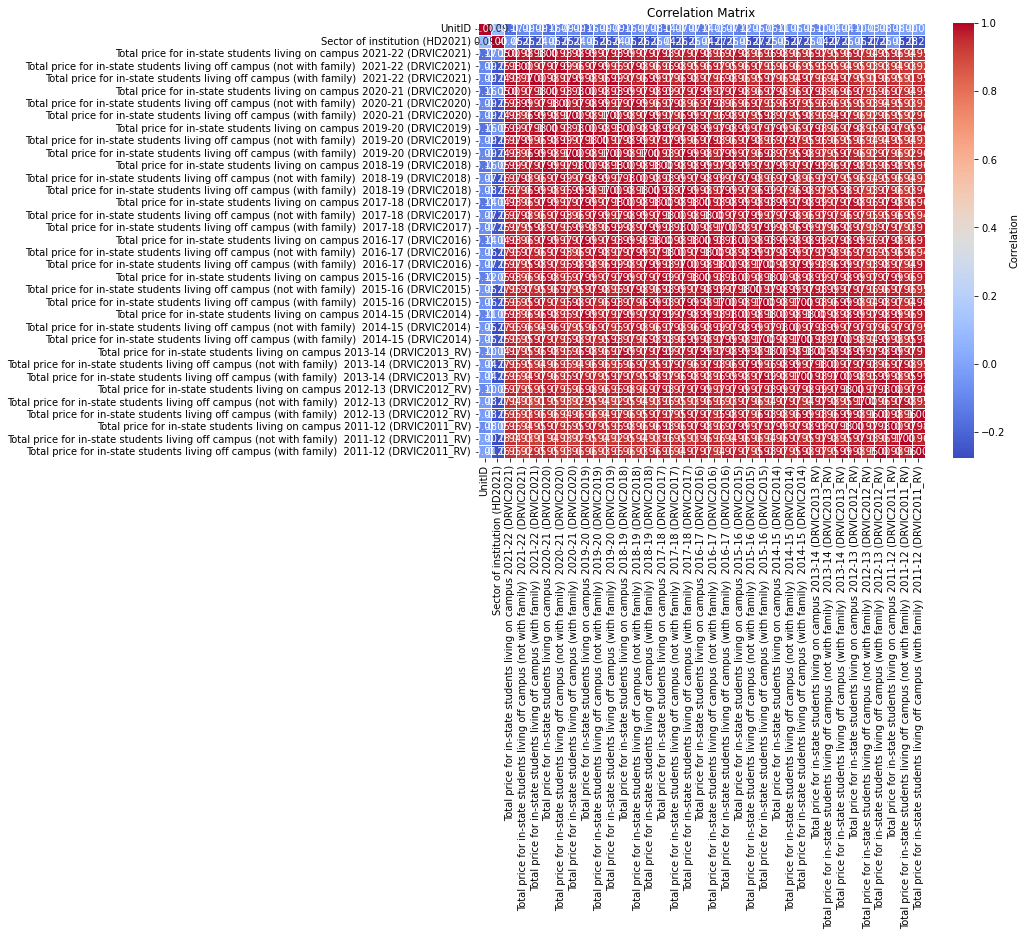

In [24]:
# assign correlation function to new variable
corr = df_sticker_price.corr()
corr

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=corr.isnull(), cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix')
plt.show()

## Release SageMaker Resources

In [25]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [26]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>